In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from itertools import *
import pandas as pd
from collections import defaultdict

In [12]:
alpha = 0.55
h = 100
top = h**alpha
def sample_displacement():
    u = rnd.random()
    return (-((u * (top - 1) - top) / top))**(-1/alpha)

In [13]:
beta = 0.8
h = 17
top2 = h**beta
def sample_delay():
    u = rnd.random()
    return (-((u * (top2 - 1) - top2) / top2))**(-1/beta)

In [14]:
def sample_numhops():
    i = 0
    h = 0
    while h < 24 * 30: 
        i += 1
        h += sample_delay()
    return i

In [15]:
def l2norm(diff):
  return np.sqrt(diff.dot(diff))

In [16]:
def halfl2norm(diff):
  return (np.sqrt(diff.dot(diff)) / 2).astype(int)

For a given frequency $f$ and even radius $r$, we plot the average over all cells of the number of visitors to this cell that came from truncated half distance $r/2$ away

In [17]:
rho = 0.6
gamma = 0.21

def walkers(n, usesq):
    freq_dist_count = np.zeros((10, 50))
    cell_dists = np.zeros((100,100))
    guestbook = [[defaultdict(int) for j in range(100)] for i in range(100)]
    # keep track of the time for each person
    # locations are now grid cells, not floats
    for i in range(n):
        cell_freq = np.zeros((100,100)).astype(int)
        visits = np.array([1.0])
        S = 1
        home = rnd.uniform(0, 300, 2)
        pos = home
        visited = [pos]
        loc = S
        for _ in range(sample_numhops() + 1):
            if loc > 1 and (pos >= 100).all() and (pos < 200).all():
                loctup = tuple(pos.astype(int) - 100)
                cell_freq[loctup] += 1
                cell_dists[loctup] += l2norm(home - pos)
                guestbook[loctup[0]][loctup[1]][tuple(home)] += 1
            if rnd.random() < rho * S ** -gamma:
                visits = np.append(visits, [1])
                S += 1
                loc = S
                theta = rnd.rand() * 2 * np.pi
                r = sample_displacement()
                h = np.array([np.cos(theta), np.sin(theta)])
                pos = pos + h * r
                visited.append(pos)
            else:
                sqvisits = np.square(visits) if usesq else visits
                loc = rnd.choice(S, p=sqvisits / sqvisits.sum())
                visits[loc] += 1
                pos = visited[loc]
        for i, col in enumerate(cell_freq):
            for j, f in enumerate(col):
                if f == 0: continue
                d = halfl2norm(home - [i+100,j+100])
                if d >= 50 or f >= 10: continue
                freq_dist_count[f-1][d] += 1
    return freq_dist_count / 1e4 , cell_dists, guestbook

In [ ]:
# should filter out trips where the number of visitors making the commute between cells <= 2

In [ ]:
# Could also compare to the centroid (minimizing distances squared). Easier.

In [ ]:
# Get the average distance per vistitor. Does it show uniformity across space, as in phone data?
visitor_counts = np.array([len(d) for d in row] for row in guestbook])
avg_dist_per_visitor = cell_dists / visitor_counts


In [18]:
def geo_medians(a, mult):
  for i in range(100):
    for j in range(100):
      yield (np.apply_along_axis(l2norm, 1, a - [i+100,j+100]) * mult).sum()

In [19]:
def webers(gb):
  for i, row in enumerate(gb):
    for j, visitors in enumerate(row):
      if len(visitors) == 0: continue
      vis = np.array(list(visitors.keys()))
      mult = np.array(list(visitors.values()))
      cur = (np.apply_along_axis(l2norm, 1, vis - [i+100,j+100]) * mult).sum()
      yield (cur - min(geo_medians(vis, mult))) / cur

In [26]:
freq_dist_count, cell_dists, guestbook = walkers(10000, False)

In [ ]:
# This is just too slow 

In [32]:
webs = list(webers(guestbook))

In [ ]:
# should really filter out those with count 0

<IPython.core.display.Javascript object>


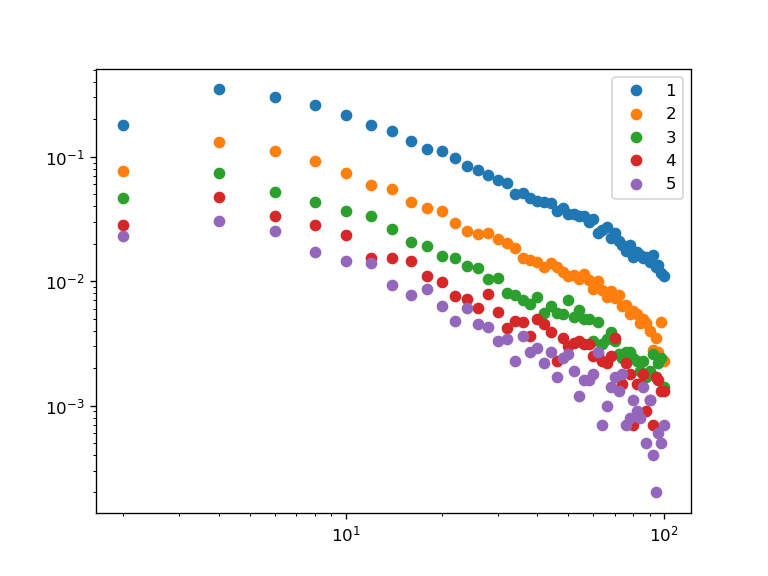

In [31]:
for f in range(5):
    xaxis = (np.arange(50) + 1) * 2
    mask = freq_dist_count[f] > 0
    plt.loglog(xaxis[mask], freq_dist_count[f][mask], 'o')
plt.legend(np.arange(5) + 1)

<IPython.core.display.Javascript object>


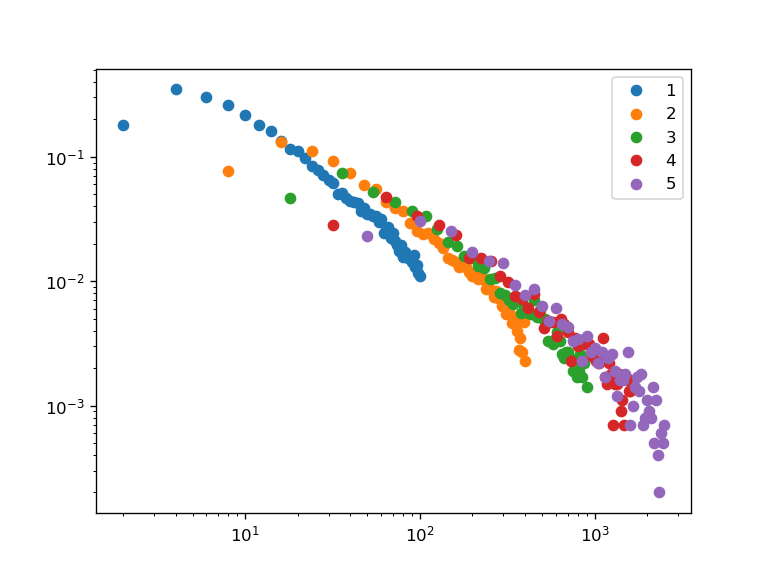

In [28]:
for f in range(5):
    xaxis = (np.arange(50) + 1) * 2 * (f+1)**2
    mask = freq_dist_count[f] > 0
    plt.loglog(xaxis[mask], freq_dist_count[f][mask], 'o')
plt.legend(np.arange(5) + 1)

In [27]:
freq_dist_count_sq, cell_dists_sq, guestbook_sq = walkers(10000, True)

<IPython.core.display.Javascript object>


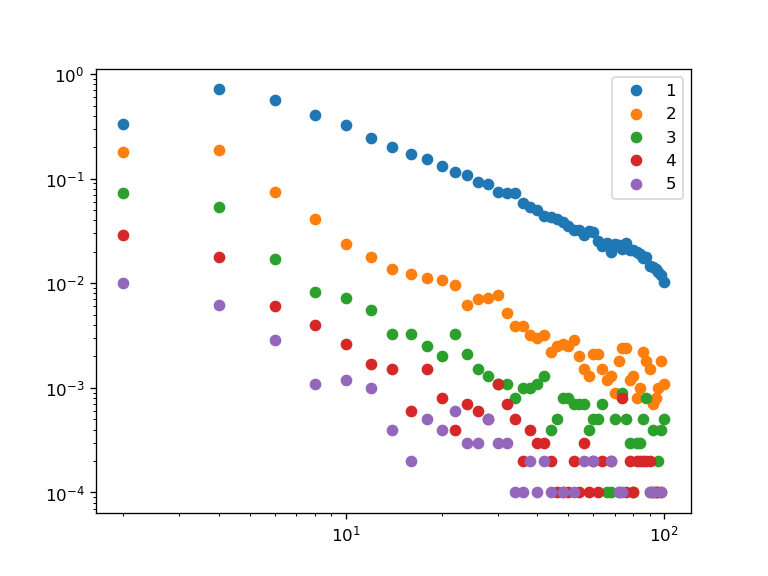

In [30]:
for f in range(5):
    xaxis = (np.arange(50) + 1) * 2
    mask = freq_dist_count_sq[f] > 0
    plt.loglog(xaxis[mask], freq_dist_count_sq[f][mask], 'o')
plt.legend(np.arange(5) + 1)

<IPython.core.display.Javascript object>


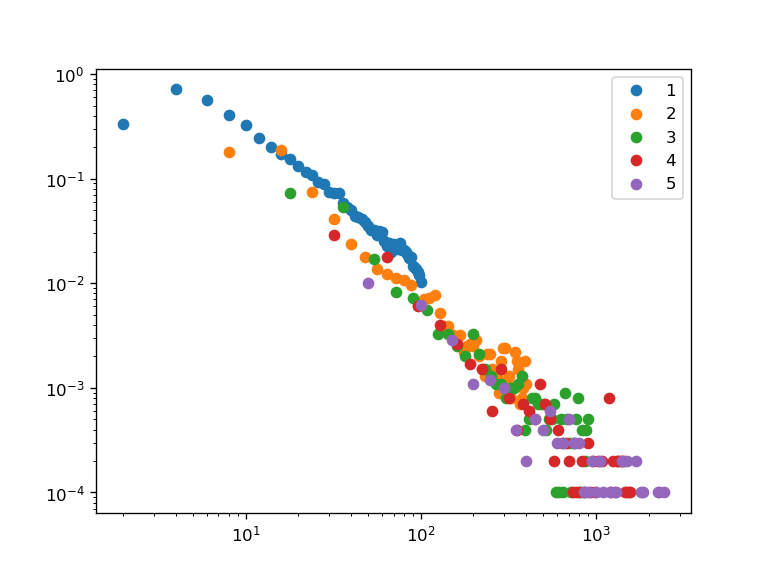

In [29]:
for f in range(5):
    xaxis = (np.arange(50) + 1) * 2 * (f+1)**2
    mask = freq_dist_count_sq[f] > 0
    plt.loglog(xaxis[mask], freq_dist_count_sq[f][mask], 'o')
plt.legend(np.arange(5) + 1)